In [16]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [21]:
class Deep_Neural_Network:
  def __init__(self,layers_dims,learning_rate=0.01,num_iterations=100,print_cost=False,activation="relu",lamda=0.1,optimizer="",batchSize=0):
    self.optimizer=optimizer.lower()
    self.beta1=0
    self.beta2=0
    self.learning_rate=learning_rate
    self.lamda=lamda
    self.activation=activation
    self.num_iterations=num_iterations
    self.X=0
    self.layers_dims=layers_dims
    self.Y=0
    self.Ym=0
    self.parameters={}
    self.costs=[]
    self.gradsOptimizer={}
    self.grads={}
    self.print_cost=print_cost
    self.m=0
    self.batch_size=batchSize
    self.mini_batches=[]
    self.accuracy=[]
    self.epsilon=1/(10**9)
  def fit(self,X,Y):
    self.X=X
    self.Y=Y
    self.m=Y.shape[1]
    self.M=self.m
    self.initialize_parameters()
    self.batch_size=self.m if(self.batch_size<=0 or self.batch_size>self.m) else self.batch_size
    self.create_batchs()
    for i in range(0, self.num_iterations):
      for (Xm,Ym) in self.mini_batches:
        self.Ym=Ym
        self.M=Ym.shape[1]
        Ym=np.argmax(Ym,axis=0).reshape(1,Ym.shape[1])
        AL, caches = self.L_model_forward(Xm,self.parameters)
        cost = self.compute_cost(AL,Ym)
        prediction=np.argmax(AL,axis=0)
        prediction=prediction.reshape(1,prediction.shape[0])
        acc=(np.sum(prediction==Ym)/self.M)*100
        self.L_model_backward(AL, caches)
        self.update_parameters()
        self.costs.append(cost)
        self.accuracy.append(acc)
      if self.print_cost and i % 100 == 0:
          print (f"Cost after iteration {i}: %f" %(cost))
    plt.plot(np.squeeze(self.costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(self.learning_rate))
    plt.show()
    plt.plot(np.squeeze(self.accuracy))
    plt.ylabel('accuracy')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(self.learning_rate))
    plt.show()
  def initialize_parameters(self):
    L=len(self.layers_dims)
    for i in range(1,L):
      self.parameters["W"+str(i)]=np.random.randn(self.layers_dims[i],self.layers_dims[i-1])*0.01
      self.parameters['b'+str(i)]=np.zeros((self.layers_dims[i],1))
      self.gradsOptimizer["vdW"+str(i)]=np.zeros((self.layers_dims[i],layers_dims[i-1]))
      self.gradsOptimizer["vdb"+str(i)]=np.zeros((self.layers_dims[i],1))
      self.gradsOptimizer["sdW"+str(i)]=np.zeros((self.layers_dims[i],layers_dims[i-1]))
      self.gradsOptimizer["sdb"+str(i)]=np.zeros((self.layers_dims[i],1)) 
      self.gradsOptimizer["vcdW"+str(i)]=np.zeros((self.layers_dims[i],layers_dims[i-1]))
      self.gradsOptimizer["vcdb"+str(i)]=np.zeros((self.layers_dims[i],1))
      self.gradsOptimizer["scdW"+str(i)]=np.zeros((self.layers_dims[i],layers_dims[i-1]))
      self.gradsOptimizer["scdb"+str(i)]=np.zeros((self.layers_dims[i],1))
    if self.optimizer=="rms":
      self.beta1=0.9
    elif self.optimizer=="momentum":
      self.beta2=0.9
    elif self.optimizer=="adam":
      self.beta1=0.9
      self.beta2=0.999
  
  def create_batchs(self):
    X=self.X.T
    Y=self.Y.T
    n=self.m//self.batch_size
    n=n-1 if (self.batch_size==1 or self.batch_size==self.m) else n
    j = 0
    for j in range(n+1):
        X_mini = X[j*self.batch_size:(j+1)*self.batch_size, :] 
        Y_mini = Y[j*self.batch_size:(j+1)*self.batch_size, :] 
        self.mini_batches.append((X_mini.T, Y_mini.T)) 
    
  def L_model_forward(self,X,parameters):
    caches=[]
    A=X
    L=len(parameters)//2
    for l in range(1,L):
      A_prev=A
      A,cache=self.linear_activation_forward(A_prev,parameters["W"+str(l)],parameters["b"+str(l)],"relu")
      caches.append(cache)
    Al,cache=self.linear_activation_forward(A,parameters["W"+str(L)],parameters["b"+str(L)],"sigmoid")
    caches.append(cache)
    return Al,caches
  def L_model_backward(self,AL,cache):
    self.grads={}
    L=len(cache)
    m=AL.shape[1]
    self.Ym = self.Ym.reshape(AL.shape)
    dAL = - (np.divide(self.Ym, AL+self.epsilon) - np.divide(1 - self.Ym, 1 - AL+self.epsilon))
    current_cache=cache[L-1]
    self.grads["dA"+str(L-1)],self.grads["dW"+str(L)],self.grads["db"+str(L)]=self.linear_activation_backward(dAL,current_cache,"sigmoid")
    for l in reversed(range(L-1)):
      current_cache=cache[l]
      dA_prev_temp,dW_temp,db_temp=self.linear_activation_backward(self.grads["dA"+str(l+1)],current_cache,"relu")
      self.grads["dA"+str(l)]=dA_prev_temp
      self.grads["dW"+str(l+1)]=dW_temp
      self.grads["db"+str(l+1)]=db_temp
      
  def sigmoid_(self,Z):
    return 1/(1+np.exp(-Z))
  
  def sigmoid(self,Z):
    return self.sigmoid_(Z),Z
  
  def relu(self,Z):
    A=Z*(Z>0)
    return A,Z
  
  def linear_forward(self,A,W,b):
    cache=(A,W,b)
    Z=np.dot(W,A)+b
    return Z,cache

  def linear_activation_forward(self,A,W,b,activation):
    Z,linear_cache=self.linear_forward(A,W,b)
    if activation=="sigmoid":
      A,activation_cache=self.sigmoid(Z)
    elif activation=="relu":
      A,activation_cache=self.relu(Z)
    cache=(linear_cache,activation_cache)
    return A,cache

  def compute_cost(self,AL,Ym):
    regTerm=0
    for i in range(1,len(layers_dims)):
      regTerm+=(np.sum(np.square(self.parameters["W"+str(i)])))
    regTerm=(self.lamda)*(regTerm)/(2*self.m)
    cost = (-(1/self.M)*np.sum((self.Ym*np.log(AL+self.epsilon))+(1-self.Ym)*np.log(1-AL+self.epsilon)))+regTerm
    cost=np.squeeze(cost)
    return cost
 
  def linear_activation_backward(self,dA,cache,activation):
    linear_cache,activation_cache=cache
    if activation=="relu":
      A=1.*(activation_cache>0)
      dZ=dA*A
      dA_prev,dW,db=self.linear_backward(dZ,linear_cache)
    elif activation=="sigmoid":
      dZ=dA*(self.sigmoid_(activation_cache)*(1-self.sigmoid_(activation_cache)))
      dA_prev,dW,db=self.linear_backward(dZ,linear_cache)
    return dA_prev,dW,db
  
  def linear_backward(self,dZ,cache):
    (A_prev,W,b)=cache
    m=A_prev.shape[1]
    dW=(1/m)*np.dot(dZ,A_prev.T)
    db=(1/m)*np.sum(dZ,axis=1,keepdims=True)
    dA_prev = np.dot(W.T,dZ)
    return dA_prev, dW, db
  
  def update_parameters(self):
    L=len(self.parameters)//2
    if self.optimizer=="rms":
      self.Rms()
      for l in range(L):
        self.parameters["W"+str(l+1)]=self.parameters["W"+str(l+1)]*(1-(self.learning_rate*self.lamda)/self.m)-(self.learning_rate/(np.sqrt(self.gradsOptimizer["sdW"+str(l+1)])+self.epsilon))*self.grads["dW"+str(l+1)]
        self.parameters["b"+str(l+1)]=self.parameters["b"+str(l+1)]-(self.learning_rate/(np.sqrt(self.gradsOptimizer["sdb"+str(l+1)])+self.epsilon))*self.grads["db"+str(l+1)]
    elif self.optimizer=="momentum":
      self.Momentum()
      for l in range(L):
        self.parameters["W"+str(l+1)]=self.parameters["W"+str(l+1)]*(1-(self.learning_rate*self.lamda)/self.m)-(self.learning_rate)*self.gradsOptimizer["vdW"+str(l+1)]
        self.parameters["b"+str(l+1)]=self.parameters["b"+str(l+1)]-(self.learning_rate*self.gradsOptimizer["vdb"+str(l+1)])
    elif self.optimizer=="adam":
      self.Adam()
      for l in range(L):
        self.parameters["W"+str(l+1)]=self.parameters["W"+str(l+1)]*(1-(self.learning_rate*self.lamda)/self.m)-(self.learning_rate/(np.sqrt(self.gradsOptimizer["scdW"+str(l+1)])+self.epsilon))*self.gradsOptimizer["vcdW"+str(l+1)]
        self.parameters["b"+str(l+1)]=self.parameters["b"+str(l+1)]-(self.learning_rate/(np.sqrt(self.gradsOptimizer["scdb"+str(l+1)])+self.epsilon))*self.gradsOptimizer["vcdb"+str(l+1)]
    else:
      for l in range(L):
        self.parameters["W"+str(l+1)]=self.parameters["W"+str(l+1)]*(1-(self.learning_rate*self.lamda)/self.m)-(self.learning_rate)*self.grads["dW"+str(l+1)]
        self.parameters["b"+str(l+1)]=self.parameters["b"+str(l+1)]-(self.learning_rate*self.grads["db"+str(l+1)])

  def Momentum(self):
     L=len(self.layers_dims)
     for i in range(1,L):
       self.gradsOptimizer["vdW"+str(i)]=self.gradsOptimizer["vdW"+str(i)]*self.beta1+(1-self.beta1)*(self.grads["dW"+str(i)])
       self.gradsOptimizer["vdb"+str(i)]=self.gradsOptimizer["vdb"+str(i)]*self.beta1+(1-self.beta1)*(self.grads["db"+str(i)])
  
  def Rms(self):
     L=len(self.layers_dims)
     for i in range(1,L):
       self.gradsOptimizer["sdW"+str(i)]=self.gradsOptimizer["sdW"+str(i)]*self.beta2+(1-self.beta2)*np.square(self.grads["dW"+str(i)])
       self.gradsOptimizer["sdb"+str(i)]=self.gradsOptimizer["sdb"+str(i)]*self.beta2+(1-self.beta2)*np.square(self.grads["db"+str(i)])
       
  def Adam(self):
    L=len(self.layers_dims)
    self.Momentum()
    self.Rms()
    for i in range(1,L):
      self.gradsOptimizer["vcdW"+str(i)]=self.gradsOptimizer["vdW"+str(i)]/(1-self.beta1)
      self.gradsOptimizer["vcdb"+str(i)]=self.gradsOptimizer["vdb"+str(i)]/(1-self.beta1)
      self.gradsOptimizer["scdW"+str(i)]=self.gradsOptimizer["sdW"+str(i)]/(1-self.beta2)
      self.gradsOptimizer["scdb"+str(i)]=self.gradsOptimizer["sdb"+str(i)]/(1-self.beta2)

  def predict_L_layer(self,X):
    AL,caches=self.L_model_forward(X,self.parameters)
    prediction=np.argmax(AL,axis=0)
    return prediction.reshape(1,prediction.shape[0])
  
  def predict(self,X,Y_):
    predictions=self.predict_L_layer(X)
    print("Training Accuracy : "+ str(np.sum(predictions==Y_)/Y_.shape[1] * 100)+" %")
    return predictions

In [22]:
from sklearn.datasets import load_digits
digits=load_digits()
n_samples=len(digits.images)


x=digits.images.reshape((n_samples,-1))

y=digits.target

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

X_train=X_train.T
X_test=X_test.T
y_train=y_train.reshape(y_train.shape[0],1)
y_test=y_test.reshape(y_test.shape[0],1)
y_train=y_train.T
y_test=y_test.T
Y_train_=np.zeros((10,y_train.shape[1]))
for i in range(y_train.shape[1]):
    Y_train_[y_train[0,i],i]=1
Y_test_=np.zeros((10,y_test.shape[1]))
for i in range(y_test.shape[1]):
    Y_test_[y_test[0,i],i]=1

Cost after iteration 0: 3.492234
Cost after iteration 100: 0.148056


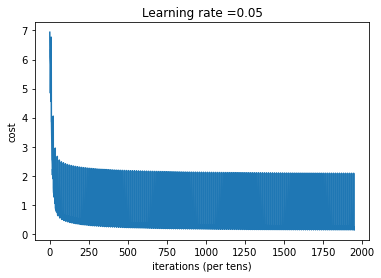

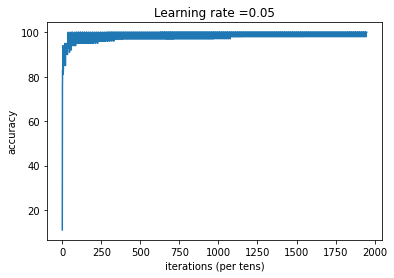

In [23]:
n_x=X_train.shape[0]
layers_dims=[n_x,10]
ob=Deep_Neural_Network(layers_dims,0.05,150,True,lamda=0.1,optimizer="adam",batchSize=100)
ob.fit(X_train,Y_train_)

In [24]:
b=ob.predict(X_train,y_train)
bb=ob.predict(X_test,y_test)

Training Accuracy : 99.44311853619729 %
Training Accuracy : 95.37037037037037 %
